In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, color, feature
from skimage.transform import rescale, resize, rotate, integral_image
from skimage.feature import haar_like_feature, haar_like_feature_coord, draw_haar_like_feature
from skimage.exposure import equalize_hist
from skimage.data import lfw_subset

from itertools import chain
from tqdm import tqdm
from random import sample
from time import time

from sklearn.feature_extraction.image import PatchExtractor
from sklearn.datasets import fetch_lfw_people
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.ensemble import BaggingClassifier
import pickle
from joblib import Parallel, delayed
from tqdm import tqdm

In [9]:

lfw_people = fetch_lfw_people()
originalImages = lfw_people.images
labels = lfw_people.target

new_resolution = (64, 64)  
#positive_patches = [resize(img, new_resolution, mode='reflect', anti_aliasing=True) for img in originalImages]
positive_patches = lfw_people.images
size = positive_patches[0].shape

imgs = ['camera',
        'text',
        'coins',
        'moon',
        'page',
        'clock',
        'immunohistochemistry',
        'chelsea',
        'coffee',
        'hubble_deep_field'
        ]

images = []
for name in imgs:
    img = getattr(data, name)()
    if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
        img = color.rgb2gray(img)
    images.append(img)

    
# Función para extraer porciones de una imagen
def extract_patches(img, N, scale=1.0, patch_size=size):
    # Calcula el tamaño del parche extraído basado en el factor de escala dado
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    
    # Inicializa un objeto PatchExtractor con el tamaño de parche calculado,
    # el número máximo de parches, y una semilla de estado aleatorio
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)
    
    # Extrae parches de la imagen dada
    # img[np.newaxis] se utiliza la entrada de PatchExtractor es un conjunto de imágenes
    patches = extractor.transform(img[np.newaxis])
    
    # Si el factor de escala no es 1, redimensiona cada parche extraído
    # al tamaño del parche original
    if scale != 1:
        patches = np.array([resize(patch, patch_size) for patch in patches])
    
    # Devuelve la lista de parches extraídos (y posiblemente redimensionados)
    return patches

# Extraemos las imágenes de fondo
negative_patches = np.vstack([extract_patches(im, 250, scale) for im in tqdm(images, desc='Procesando imágenes') for scale in [0.5, 0.75, 1.0, 1.5, 2.0]])
negative_patches.shape

X_train = np.array([feature.hog(im) for im in tqdm(chain(positive_patches, negative_patches), desc='Construyendo X')])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1




Procesando imágenes: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]
Construyendo X: 25733it [00:21, 1223.68it/s]


In [5]:
# AdaBoost clasifier

# Bad clasifier
weak_classifier = DecisionTreeClassifier(max_depth=1)
# Good clasifier based in the bad one (for better results, increase the number of estimators)
adaboost_classifier = AdaBoostClassifier(estimator=weak_classifier, n_estimators=5, random_state=0)

adaboost_classifier.fit(X_train, y_train)

predictions = adaboost_classifier.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

recall = recall_score(y_test, predictions)
print(f'Recall: {recall}')

# Focus on TNR (predict non-faces correctly)
y_pred = adaboost_classifier.predict(X_test)
y_true = y_test

conf_matrix = confusion_matrix(y_true, y_pred)
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
tnr = tn / (tn + fp)
print(f'True Negative Rate (TNR): {tnr}')

Accuracy: 0.98
Recall: 0.96
True Negative Rate (TNR): 1.0


In [6]:
# Base clasifier for Bagging model
base_classifier = DecisionTreeClassifier(max_depth=2)

# Added adaboost as a bagging base classifier
bagging_classifier = BaggingClassifier(base_classifier, n_estimators=5, random_state=0)

bagging_classifier.fit(X_train, y_train)

y_pred = bagging_classifier.predict(X_test)
y_true = y_test

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

conf_matrix = confusion_matrix(y_true, y_pred)
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
tnr = tn / (tn + fp)

recall = recall_score(y_true, y_pred)

print(f'Recall: {recall}')
print(f'True Negative Rate (TNR): {tnr}')

Accuracy: 0.98
Recall: 1.0
True Negative Rate (TNR): 0.96


In [9]:
# Train a random forest classifier and assess its performance
clf = RandomForestClassifier(n_estimators=1000, max_depth=None,
                             max_features=100, n_jobs=-1, random_state=0)
t_start = time()
clf.fit(X_train, y_train)
time_full_train = time() - t_start
auc_full_features = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])



c:\Users\naist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\naist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

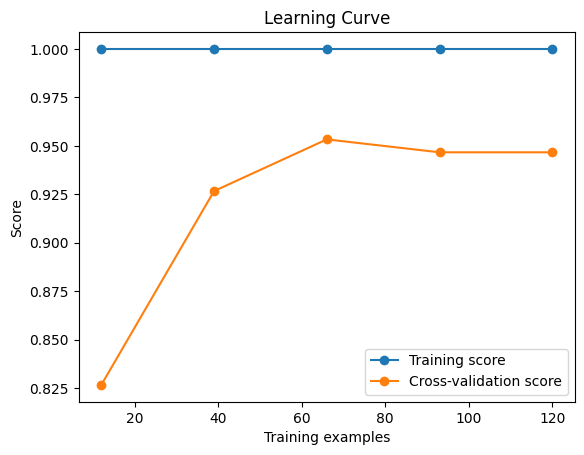

In [ ]:
#TARDA 10 MINUTOS (Hacete un tecito)

clf = LogisticRegression(max_iter=500)
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=5)

plt.figure()
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label="Training score")
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

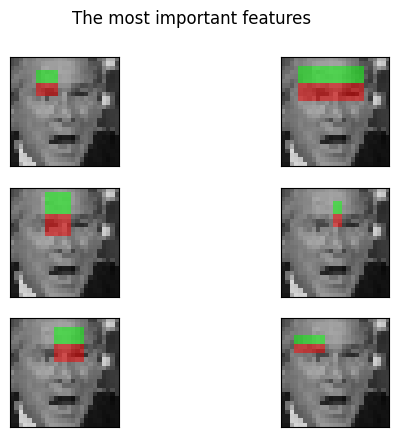

In [ ]:
# Sort features in order of importance and plot the six most significant
idx_sorted = np.argsort(clf.feature_importances_)[::-1]

fig, axes = plt.subplots(3, 2)
for idx, ax in enumerate(axes.ravel()):
    image = images[0]
    image = draw_haar_like_feature(image, 0, 0,
                                   images.shape[2],
                                   images.shape[1],
                                   [feature_coord[idx_sorted[idx]]])
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])
    _ = fig.suptitle('The most important features')


